In [131]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import pylab
from scipy.optimize import curve_fit
#from matplotlib import *
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import *

**Created function that prepares the initial state of the qubit. In this case we prepare it in the singlet state**

In [132]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q, c)

simulator = Aer.get_backend('qasm_simulator')

# Thermal Relaxation: 

In [133]:
circ = QuantumCircuit(q, c)
circ.x(0)

thermalCounts = []
timeStep = 50
rangeVal = 80
for i in range(rangeVal):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, 4) # Is a bell curve with the center at the first parameter with a distribution of the second parameter
    T2s = np.random.normal(70e3, 10e3, 4)  # same thing

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = timeStep * i # 1 microsecond # was originally 1000

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                      for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                  for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                 thermal_relaxation_error(t1b, t2b, time_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(4):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(4):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    circ.measure(q, c)
    #print(noise_thermal)
    # Run the noisy simulation
    job = execute(circ, simulator,
                  basis_gates=noise_thermal.basis_gates,
                  noise_model=noise_thermal)
    result_thermal = job.result()
    counts_thermal = result_thermal.get_counts(0)
    # Plot noisy output
    #plot_histogram(counts_thermal)
    thermalCounts.append(counts_thermal)
    plot_histogram(counts_thermal, title="Thermal Relaxation Error")

    
#print(thermalCounts)
#######This will prove the relationship between time waited to measure and the state of the qubit#######
xPoints = []
yPoints = []
for i in range(len(thermalCounts)):
    xPoints.append(i*timeStep)
    yPoints.append(thermalCounts[i].get('0', 0)/(thermalCounts[i].get('0', 0) + thermalCounts[i].get('1', 0)))

# print(xPoints)
# print(yPoints)



**Plotting the temperature-time relationship**

As a fun side experiment I decided to plot the influence of temperature relaxation on a single qubit (how close the qubit is to it's 0 or 1 state) after a certian amount of time. Currently it is commented out but before I made a plot that showed that the state would increase quickly to the 0 state and then level off.


**Info about the graph**

1.0 = |0> state and 0.0 = |1> state

Time is measured in microseconds

In [134]:
def sigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

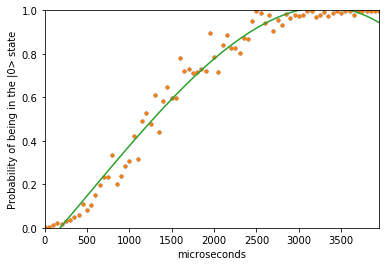

In [143]:
plt.axis([0, rangeVal * timeStep, 0, 1])
plt.xlabel('microseconds')
plt.ylabel('Probability of being in the |0> state')
plt.plot(xPoints, yPoints, ".")

z = np.polyfit(xPoints, yPoints, 3)
f = np.poly1d(z)
x_new = np.linspace(xPoints[0], xPoints[-1], 50)
y_new = f(x_new)


plt.plot(xPoints, yPoints,'.', x_new, y_new)
plt.xlim([xPoints[0]-1, xPoints[-1] + 1 ])

plt.show()